
<CENTER><img src=https://upload.wikimedia.org/wikipedia/commons/8/84/URJC_logo.svg></CENTER>


 
## <center>  ANÁLISIS DEL ESTADO ANÍMICO DE LA SOCIEDAD EN EL COVID-19 A TRAVÉS DE TWEETS
<center> (Código correspondiente a tres salidas: positivo, neutro y negativo)

**Base de datos con la que se ha trabajado:**


https://www.kaggle.com/datatattle/covid-19-nlp-text-classification 

## Importamos los datos y las librerías

In [ ]:
import os
from os import listdir, mkdir

import pandas as pd

from matplotlib import pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
from nltk.tokenize import word_tokenize

import re
import string

from sklearn import preprocessing

import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.metrics import accuracy_score
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import classification_report, confusion_matrix

from sklearn import linear_model
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import RandomForestClassifier

- Importamos los datos de una carpeta creada en google drive.

In [ ]:
from google.colab import drive 
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
dir = "/content/drive/MyDrive/MI_PMD/"
folders = os.listdir(dir)
print(folders)

['Corona_NLP_test.csv', 'Corona_NLP_train.csv']


## Datos

- Aprovechamos que ya vienen los datos divididos en train y test creando una variable para cada csv.


- Utilizamos el encoding IBM437 que conforme al siguiente enlace es recomendable para textos en inglés, idioma en el que se encuentran los tweets recopilados en la base. https://docs.python.org/3/library/codecs.html#standard-encodings  

In [ ]:
df_train = pd.read_csv(dir+'Corona_NLP_train.csv', encoding = "IBM437")
df_test = pd.read_csv(dir+'Corona_NLP_test.csv',encoding = "IBM437")

In [ ]:
df_train = pd.read_csv("Corona_NLP_train.csv",encoding = "IBM437")
df_test = pd.read_csv("Corona_NLP_test.csv",encoding = "IBM437")


In [ ]:
df_train.OriginalTweet[1]

'advice Talk to your neighbours family to exchange phone numbers create contact list with phone numbers of neighbours schools employer chemist GP set up online shopping accounts if poss adequate supplies of regular meds but not over order'

- Podemos obervar con las dimensiones de cada variable que en la división que viene hecha, el conjunto de train supone un 91% y el de test un 9%.

In [ ]:
print(df_train.shape,df_test.shape)

(41157, 6) (3798, 6)


In [ ]:
df_train.head(10)

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
0,3799,48751,London,16-03-2020,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral
1,3800,48752,UK,16-03-2020,advice Talk to your neighbours family to excha...,Positive
2,3801,48753,Vagabonds,16-03-2020,Coronavirus Australia: Woolworths to give elde...,Positive
3,3802,48754,NaN,16-03-2020,My food stock is not the only one which is emp...,Positive
4,3803,48755,NaN,16-03-2020,"Me, ready to go at supermarket during the #COV...",Extremely Negative
5,3804,48756,"├£T: 36.319708,-82.363649",16-03-2020,As news of the region┬Æs first confirmed COVID...,Positive
6,3805,48757,"35.926541,-78.753267",16-03-2020,Cashier at grocery store was sharing his insig...,Positive
7,3806,48758,Austria,16-03-2020,Was at the supermarket today. Didn't buy toile...,Neutral
8,3807,48759,"Atlanta, GA USA",16-03-2020,Due to COVID-19 our retail store and classroom...,Positive
9,3808,48760,"BHAVNAGAR,GUJRAT",16-03-2020,"For corona prevention,we should stop to buy th...",Negative


In [ ]:
df_test.head(10)

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
0,1,44953,NYC,02-03-2020,TRENDING: New Yorkers encounter empty supermar...,Extremely Negative
1,2,44954,"Seattle, WA",02-03-2020,When I couldn't find hand sanitizer at Fred Me...,Positive
2,3,44955,NaN,02-03-2020,Find out how you can protect yourself and love...,Extremely Positive
3,4,44956,Chicagoland,02-03-2020,#Panic buying hits #NewYork City as anxious sh...,Negative
4,5,44957,"Melbourne, Victoria",03-03-2020,#toiletpaper #dunnypaper #coronavirus #coronav...,Neutral
5,6,44958,Los Angeles,03-03-2020,Do you remember the last time you paid $2.99 a...,Neutral
6,7,44959,NaN,03-03-2020,Voting in the age of #coronavirus = hand sanit...,Positive
7,8,44960,"Geneva, Switzerland",03-03-2020,"@DrTedros ""We can┬Æt stop #COVID19 without pro...",Neutral
8,9,44961,NaN,04-03-2020,HI TWITTER! I am a pharmacist. I sell hand san...,Extremely Negative
9,10,44962,"Dublin, Ireland",04-03-2020,Anyone been in a supermarket over the last few...,Extremely Positive


- Mostramos analíticamente la distribución de los tweets en las diferentes salidas que de momento son cinco posibles: extremadamente negativo, negativo, neutro, positivo y extremadamente positivo.

In [ ]:
print('Para los datos de entrenamiento:',df_train["Sentiment"].value_counts())
print('Para los datos de test:',df_test["Sentiment"].value_counts())

Para los datos de entrenamiento: Positive              11422
Negative               9917
Neutral                7713
Extremely Positive     6624
Extremely Negative     5481
Name: Sentiment, dtype: int64
Para los datos de test: Negative              1041
Positive               947
Neutral                619
Extremely Positive     599
Extremely Negative     592
Name: Sentiment, dtype: int64


- Mostramos gráficamente la distribución de los datos en las diferentes salidas para ser si está balanceada la base.


- Se puede apreciar en los histogramas que en la base de test hay algunos más casos de negativos que de positivos mientras que en el conjunto train es al contrario. No hay un desbalanceo que genere una desigualdad lo suficientemente destacable como para realizar oversampling.

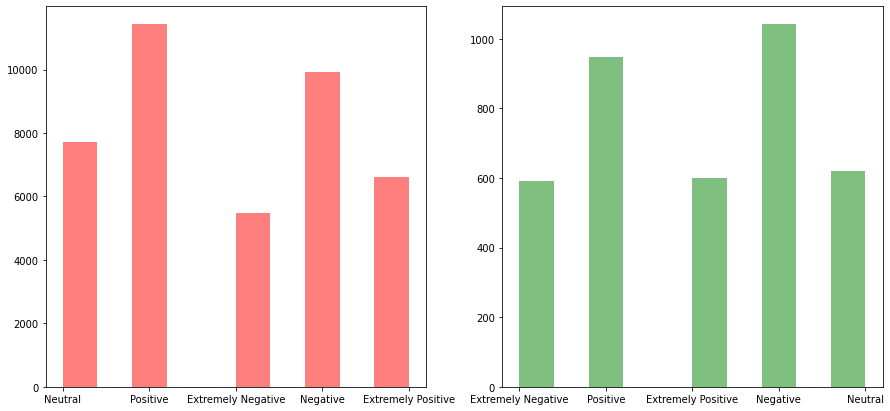

In [ ]:
fig, ax = plt.subplots(1,2,figsize=(15,7))
ax[0].hist(df_train["Sentiment"],alpha = 0.5, color = 'r')
ax[1].hist(df_test["Sentiment"],alpha = 0.5, color = 'g')
plt.show()

- Analizamos la cantidad de valores nulos y a qué columnas afectan. Se puede ver que afecta únicamente a localización por lo que no tendría sentido eliminar aquellos usuarios de los que no tenemos localización cuando sí se puede realizar el objetivo principal del proyecto consistente en relacionar el tweet con los sentimientos expresados.

In [ ]:
df_train.isnull().sum()

UserName            0
ScreenName          0
Location         8590
TweetAt             0
OriginalTweet       0
Sentiment           0
dtype: int64

In [ ]:
df_test.isnull().sum()

UserName           0
ScreenName         0
Location         834
TweetAt            0
OriginalTweet      0
Sentiment          0
dtype: int64

- Vamos a unificar etiquetas y a cambiarlas. De esta manera agruparemos en la etiqueta positiva las anteriores extremadamente positivo y positivo, de la misma manera con la salida negativa.

In [ ]:
#Para el conjunto de train
for i in range(0,len(df_train)):
    if(df_train['Sentiment'][i]=='Extremely Negative'):
        df_train['Sentiment'][i]='Negative'
    elif(df_train['Sentiment'][i]=='Extremely Positive'):
        df_train['Sentiment'][i]='Positive'

#Para el conjunto de test
for i in range(0,len(df_test)):
    if(df_test['Sentiment'][i]=='Extremely Negative'):
        df_test['Sentiment'][i]='Negative'
    elif(df_test['Sentiment'][i]=='Extremely Positive'):
        df_test['Sentiment'][i]='Positive'

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()
/usr/local/li

- Mostramos analíticamente la distribución de los datos.

In [ ]:
print('Para los datos de entrenamiento:',df_train["Sentiment"].value_counts())
print('Para los datos de test:',df_test["Sentiment"].value_counts())

Para los datos de entrenamiento: Positive    18046
Negative    15398
Neutral      7713
Name: Sentiment, dtype: int64
Para los datos de test: Negative    1633
Positive    1546
Neutral      619
Name: Sentiment, dtype: int64


- Mostramos gráficamente la distribución de los datos. Se puede observar que tanto en train como en test la cantidad de tweets en los que hay sentimientos positivos es similar a la de tweets negativos pero los tweets neutros son mucho menores. Esto es consecuencia de haber agrupado dos conjuntos de datos para positivo y otros dos para negativo de la base original habiendo mucho más de estos que de neutro. Será importante tenerlo en cuenta para la interpretación final de los resultados.

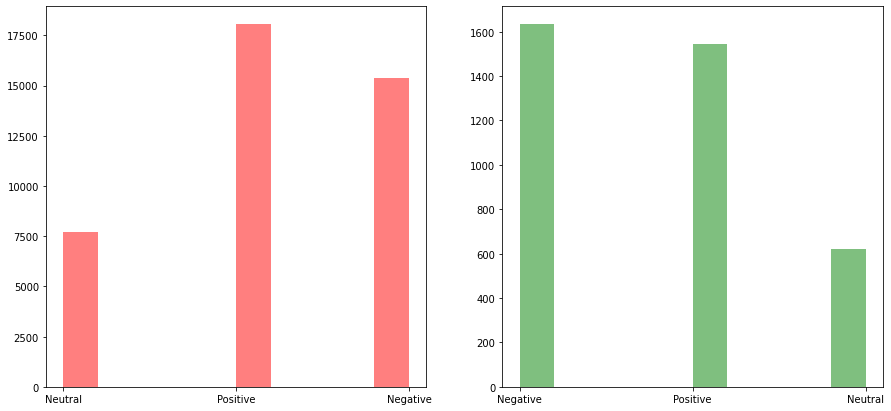

In [ ]:
fig, ax = plt.subplots(1,2,figsize=(15,7))
ax[0].hist(df_train["Sentiment"],alpha = 0.5, color = 'r')
ax[1].hist(df_test["Sentiment"],alpha = 0.5, color = 'g')
plt.show()

- Pasamos las etiquetas de palabras a números categóricos.

In [ ]:
# Para el conjunto de train
label_encoder = preprocessing.LabelEncoder()
df_train['Sentiment']= label_encoder.fit_transform(df_train['Sentiment'])
df_train['Sentiment'].unique()

#Para el conjunto de test
label_encoder2 = preprocessing.LabelEncoder()
df_test['Sentiment']= label_encoder2.fit_transform(df_test['Sentiment'])
df_test['Sentiment'].unique()


array([0, 2, 1])

In [ ]:
df_train.head(10)

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
0,3799,48751,London,16-03-2020,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,1
1,3800,48752,UK,16-03-2020,advice Talk to your neighbours family to excha...,2
2,3801,48753,Vagabonds,16-03-2020,Coronavirus Australia: Woolworths to give elde...,2
3,3802,48754,NaN,16-03-2020,My food stock is not the only one which is emp...,2
4,3803,48755,NaN,16-03-2020,"Me, ready to go at supermarket during the #COV...",0
5,3804,48756,"├£T: 36.319708,-82.363649",16-03-2020,As news of the region┬Æs first confirmed COVID...,2
6,3805,48757,"35.926541,-78.753267",16-03-2020,Cashier at grocery store was sharing his insig...,2
7,3806,48758,Austria,16-03-2020,Was at the supermarket today. Didn't buy toile...,1
8,3807,48759,"Atlanta, GA USA",16-03-2020,Due to COVID-19 our retail store and classroom...,2
9,3808,48760,"BHAVNAGAR,GUJRAT",16-03-2020,"For corona prevention,we should stop to buy th...",0


In [ ]:
df_test.head(10)

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
0,1,44953,NYC,02-03-2020,TRENDING: New Yorkers encounter empty supermar...,0
1,2,44954,"Seattle, WA",02-03-2020,When I couldn't find hand sanitizer at Fred Me...,2
2,3,44955,NaN,02-03-2020,Find out how you can protect yourself and love...,2
3,4,44956,Chicagoland,02-03-2020,#Panic buying hits #NewYork City as anxious sh...,0
4,5,44957,"Melbourne, Victoria",03-03-2020,#toiletpaper #dunnypaper #coronavirus #coronav...,1
5,6,44958,Los Angeles,03-03-2020,Do you remember the last time you paid $2.99 a...,1
6,7,44959,NaN,03-03-2020,Voting in the age of #coronavirus = hand sanit...,2
7,8,44960,"Geneva, Switzerland",03-03-2020,"@DrTedros ""We can┬Æt stop #COVID19 without pro...",1
8,9,44961,NaN,04-03-2020,HI TWITTER! I am a pharmacist. I sell hand san...,0
9,10,44962,"Dublin, Ireland",04-03-2020,Anyone been in a supermarket over the last few...,2


## Preprocesado de los datos

- En este apartado se llevará a cabo el acondicionamiento de los datos para poder obtener unos resultados de predicción buenos.


- Creamos las funciones que eliminarán signos de puntuación y tildes que no aportarán información alguna para la predicción de sentimientos.

In [ ]:
def clean_text_round1(text):
    '''Make text lowercase, remove text in square brackets, remove punctuation and remove words containing numbers.'''
    text = text.lower()
    text = re.sub('\[.*?¿\]\%', ' ', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), ' ', text)
    text = re.sub('\w*\d\w*', '', text)
    return text
def clean_text_round2(text):
    '''Get rid of some additional punctuation and non-sensical text that was missed the first time around.'''
    text = re.sub('[‘’“”…«»]', '', text)
    text = re.sub('\n', ' ', text)
    return text
def eliminar_tilde(text):
    text=text.replace("á","a")
    text=text.replace("é","e")
    text=text.replace("í","i")
    text=text.replace("ó","o")
    text=text.replace("ú","u")
    return text

In [ ]:
for k in range(0,len(df_train['OriginalTweet'])):
    clean1=clean_text_round1(df_train['OriginalTweet'][k])
    clean2=clean_text_round2(clean1)
    df_train['OriginalTweet'][k]=eliminar_tilde(clean2)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [ ]:
for k in range(0,len(df_test['OriginalTweet'])):
    clean1=clean_text_round1(df_test['OriginalTweet'][k])
    clean2=clean_text_round2(clean1)
    df_test['OriginalTweet'][k]=eliminar_tilde(clean2)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [ ]:
df_train.OriginalTweet[1]

'advice talk to your neighbours family to exchange phone numbers create contact list with phone numbers of neighbours schools employer chemist gp set up online shopping accounts if poss adequate supplies of regular meds but not over order'

- Eliminamos las stopwords ya que son palabras innecesarias que tampoco aportarán información alguna. Se realizará a partir de un diccionario de nltk. Hacemos el proceso tanto en el conjunto de test como de train

In [ ]:
nltk.download('punkt')
nltk.download('stopwords')
print("")
stop_words = set(stopwords.words('english'))

for k in range(0,len(df_test['OriginalTweet'])):

  texto = df_train.OriginalTweet[k]

  #function to split text into word
  tokens = word_tokenize(texto)

  vocabulary = set(tokens)
  df_train.OriginalTweet[k] = " ".join([w for w in tokens if not w in stop_words])

for k in range(0,len(df_test['OriginalTweet'])):

  texto = df_test.OriginalTweet[k]

  #function to split text into word
  tokens = word_tokenize(texto)

  vocabulary = set(tokens)
  df_test.OriginalTweet[k] = " ".join([w for w in tokens if not w in stop_words])

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [ ]:
df_train.OriginalTweet[1]

'advice talk neighbours family exchange phone numbers create contact list phone numbers neighbours schools employer chemist gp set online shopping accounts poss adequate supplies regular meds order'

- A continuación vamos a ver que palabras se repiten con mayor frecuencia en el conjunto de train. También se incluye un histograma que lo muestra


Cantidad de palabras distintas:  57451
Ejemplos de stopwords: ['our', 'myself', 'its', 'theirs', 'hers', 'only', 'again', 'she', 'should', 'didn']
Diez palabras con mayor frecuencia:  ['co', 'https', 'coronavirus', 'covid', 'prices', 'food', 'supermarket', 'store', 'grocery', 'people']


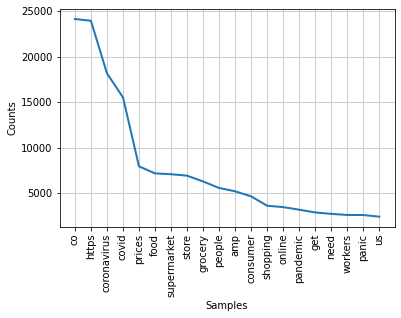

In [ ]:
texto = df_train.OriginalTweet.str.cat(sep=' ')

#function to split text into word
tokens = word_tokenize(texto)

vocabulary = set(tokens)
print("Cantidad de palabras distintas: ", len(vocabulary))


stop_words = set(stopwords.words('english'))
print("Ejemplos de stopwords:", list(stop_words)[0:10])
tokens = [w for w in tokens if not w in stop_words]
frequency_dist = nltk.FreqDist(tokens)
print("Diez palabras con mayor frecuencia: ", sorted(frequency_dist,key=frequency_dist.__getitem__, reverse=True)[0:10])
frequency_dist.plot(20,cumulative=False)

Tambien generamos un Wordcloud con estas palabras

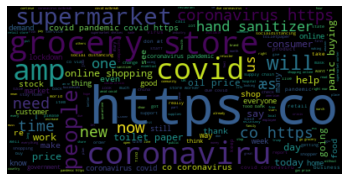

In [ ]:
# Create and generate a word cloud image:
wordcloud = WordCloud().generate(texto)

# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

- A continuación vamos a ver que palabras se repiten con mayor frecuencia en el conjunto de test. También se incluye un histograma que lo muestra

---

Cantidad de palabras distintas:  11823
Ejemplos de stopwords: ['our', 'myself', 'its', 'theirs', 'hers', 'only', 'again', 'she', 'should', 'didn']
Diez palabras con mayor frecuencia:  ['covid', 'co', 'https', 'coronavirus', 'food', 'store', 'grocery', 'stock', 'people', 'amp']


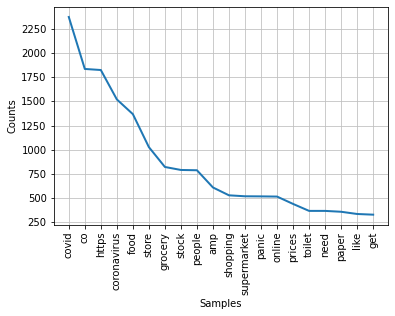

In [ ]:
texto = df_test.OriginalTweet.str.cat(sep=' ')
#function to split text into word
tokens = word_tokenize(texto)
vocabulary = set(tokens)
print("Cantidad de palabras distintas: ", len(vocabulary))
stop_words = set(stopwords.words('english'))
print("Ejemplos de stopwords:", list(stop_words)[0:10])
tokens = [w for w in tokens if not w in stop_words]
frequency_dist = nltk.FreqDist(tokens)
print("Diez palabras con mayor frecuencia: ", sorted(frequency_dist,key=frequency_dist.__getitem__, reverse=True)[0:10])
frequency_dist.plot(20,cumulative=False)

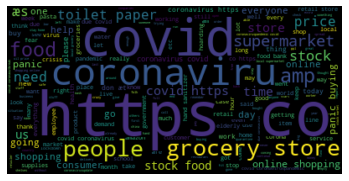

In [ ]:
wordcloud = WordCloud().generate(texto)

# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

- Codificamos el texto en números de manera que así los modelos puedan realizar un entrenamiento adecuado.

In [ ]:
df_train.OriginalTweet[1]

'advice talk neighbours family exchange phone numbers create contact list phone numbers neighbours schools employer chemist gp set online shopping accounts poss adequate supplies regular meds order'

In [ ]:
X_train=df_train["OriginalTweet"]
y_train=df_train["Sentiment"]
X_test=df_test["OriginalTweet"]
y_test=df_test["Sentiment"]

vectorizer = TfidfVectorizer()
train_vectors = vectorizer.fit_transform(X_train)
test_vectors = vectorizer.transform(X_test)

## Entrenamiento de modelos

- En este apartado se lleva a cabo el entrenamiento de una serie de modelos a partir de los datos preprocesados. Los modelos nos permitirán lograr el objetivo del proyecto, conocer los sentimientos a partir de un tweet relacionado con el covid.

### MultinomialNB y SGDClassifier

In [ ]:
clf =  MultinomialNB().fit(train_vectors, y_train)
predicted = clf.predict(test_vectors)

print(accuracy_score(y_test,predicted))
print(confusion_matrix(y_test,predicted))
print(classification_report(y_test,predicted))

0.6424433912585571
[[1058    1  574]
 [ 163    9  447]
 [ 173    0 1373]]
              precision    recall  f1-score   support

           0       0.76      0.65      0.70      1633
           1       0.90      0.01      0.03       619
           2       0.57      0.89      0.70      1546

    accuracy                           0.64      3798
   macro avg       0.74      0.52      0.47      3798
weighted avg       0.71      0.64      0.59      3798



In [ ]:

clf =  SGDClassifier().fit(train_vectors, y_train)
predicted = clf.predict(test_vectors)

print(accuracy_score(y_test,predicted))
print(confusion_matrix(y_test,predicted))
print(classification_report(y_test,predicted))

0.7793575566087414
[[1283   91  259]
 [ 129  378  112]
 [ 200   47 1299]]
              precision    recall  f1-score   support

           0       0.80      0.79      0.79      1633
           1       0.73      0.61      0.67       619
           2       0.78      0.84      0.81      1546

    accuracy                           0.78      3798
   macro avg       0.77      0.75      0.75      3798
weighted avg       0.78      0.78      0.78      3798



### Red convolucional



In [ ]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer


In [ ]:
%load_ext tensorboard
from __future__ import absolute_import, division, print_function, unicode_literals

# Install TensorFlow
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass

import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
from datetime import datetime
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils.np_utils import to_categorical

In [ ]:
df = pd.read_csv(dir+'Corona_NLP_train.csv', encoding = "ISO-8859-1")
df = df[['OriginalTweet', 'Sentiment']]

In [ ]:
def getAnalysis(score):
    if score == 'Negative' or score == 'Extremely Negative':
        return 0
    else:
        return 1
df['Sentiment'] = df['Sentiment'].apply(getAnalysis)

In [ ]:
tokenizer = Tokenizer(num_words=1500, split=' ')
tokenizer.fit_on_texts(df['OriginalTweet'].values)

X = tokenizer.texts_to_sequences(df['OriginalTweet'])
X = pad_sequences(X)

In [ ]:
Le = LabelEncoder()
y = Le.fit_transform(df['Sentiment'])

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.15)

In [ ]:
input_size=train_vectors.shape[1]
embed_dim=128
lstm_out=196

In [ ]:
mlp_model = tf.keras.Sequential([
        tf.keras.layers.Embedding(1500, embed_dim,input_length=28),
        tf.keras.layers.LSTM(lstm_out, dropout=0.2, recurrent_dropout=0.2),
        tf.keras.layers.Dense(1, activation='softmax')
    ])

In [ ]:
mlp_model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'],)
mlp_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 28, 128)           192000    
_________________________________________________________________
lstm (LSTM)                  (None, 196)               254800    
_________________________________________________________________
dense (Dense)                (None, 1)                 197       
Total params: 446,997
Trainable params: 446,997
Non-trainable params: 0
_________________________________________________________________


In [ ]:
mlp_model.fit(X_train, y_train, validation_data=(X_test,y_test), epochs=5, batch_size=32)


Epoch 1/5


UnimplementedError: ignored

In [ ]:
mlp_model.evaluate(X_test,y_test)



193/193 [==============================] - 8s 43ms/step - loss: 0.3881 - accuracy: 0.6234


[0.388103723526001, 0.623420774936676]

In [ ]:
mlp_pred=mlp_model.predict(X_test)
print(confusion_matrix(y_test,mlp_pred))

[[   0 2325]
 [   0 3849]]


### Regresión Logística


In [ ]:
model = linear_model.LogisticRegression()
model.fit(train_vectors,y_train)
y_pred=model.predict(test_vectors) 

print(accuracy_score(y_test,y_pred))
print(confusion_matrix(y_test,y_pred))
print(classification_report(y_test,y_pred))

0.7848867825171143
[[1240  155  238]
 [  83  450   86]
 [ 171   84 1291]]
              precision    recall  f1-score   support

           0       0.83      0.76      0.79      1633
           1       0.65      0.73      0.69       619
           2       0.80      0.84      0.82      1546

    accuracy                           0.78      3798
   macro avg       0.76      0.77      0.77      3798
weighted avg       0.79      0.78      0.79      3798



/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


### Extra trees

In [ ]:
# GridSearch con ExtraTrees

# Usamos gridsearch para evaluar los parámetros
modelo = ExtraTreesClassifier(n_estimators = 40,criterion='gini',min_samples_split=2 ,min_samples_leaf=3,
              verbose=3,bootstrap=True)
trees = modelo.fit(train_vectors, y_train)

# Predecimos usando X_test
y_pred = trees.predict(test_vectors)


print(classification_report(y_test,y_pred))


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s


building tree 1 of 40
building tree 2 of 40


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.3s remaining:    0.0s


building tree 3 of 40
building tree 4 of 40
building tree 5 of 40
building tree 6 of 40
building tree 7 of 40
building tree 8 of 40
building tree 9 of 40
building tree 10 of 40
building tree 11 of 40
building tree 12 of 40
building tree 13 of 40
building tree 14 of 40
building tree 15 of 40
building tree 16 of 40
building tree 17 of 40
building tree 18 of 40
building tree 19 of 40
building tree 20 of 40
building tree 21 of 40
building tree 22 of 40
building tree 23 of 40
building tree 24 of 40
building tree 25 of 40
building tree 26 of 40
building tree 27 of 40
building tree 28 of 40
building tree 29 of 40
building tree 30 of 40
building tree 31 of 40
building tree 32 of 40
building tree 33 of 40
building tree 34 of 40
building tree 35 of 40
building tree 36 of 40
building tree 37 of 40
building tree 38 of 40
building tree 39 of 40
building tree 40 of 40
              precision    recall  f1-score   support

           0       0.79      0.69      0.74      1633
           1       0.71 

[Parallel(n_jobs=1)]: Done  40 out of  40 | elapsed:    5.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  40 out of  40 | elapsed:    0.1s finished


### Random forest

In [ ]:
# GridSearch con ExtraTrees

# Usamos gridsearch para evaluar los parámetros
modelo = RandomForestClassifier(criterion='gini',min_samples_split=2 ,min_samples_leaf=3,
              verbose=3,bootstrap=True)
trees = modelo.fit(train_vectors, y_train)

# Predecimos usando X_test
y_pred = trees.predict(test_vectors)


print(classification_report(y_test,y_pred))

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s remaining:    0.0s


building tree 1 of 100
building tree 2 of 100


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.4s remaining:    0.0s


building tree 3 of 100
building tree 4 of 100
building tree 5 of 100
building tree 6 of 100
building tree 7 of 100
building tree 8 of 100
building tree 9 of 100
building tree 10 of 100
building tree 11 of 100
building tree 12 of 100
building tree 13 of 100
building tree 14 of 100
building tree 15 of 100
building tree 16 of 100
building tree 17 of 100
building tree 18 of 100
building tree 19 of 100
building tree 20 of 100
building tree 21 of 100
building tree 22 of 100
building tree 23 of 100
building tree 24 of 100
building tree 25 of 100
building tree 26 of 100
building tree 27 of 100
building tree 28 of 100
building tree 29 of 100
building tree 30 of 100
building tree 31 of 100
building tree 32 of 100
building tree 33 of 100
building tree 34 of 100
building tree 35 of 100
building tree 36 of 100
building tree 37 of 100
building tree 38 of 100
building tree 39 of 100
building tree 40 of 100
building tree 41 of 100
building tree 42 of 100
building tree 43 of 100
building tree 44 of 100

[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:   17.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.2s finished


              precision    recall  f1-score   support

           0       0.73      0.69      0.71      1633
           1       0.59      0.52      0.55       619
           2       0.70      0.78      0.74      1546

    accuracy                           0.70      3798
   macro avg       0.67      0.66      0.67      3798
weighted avg       0.70      0.70      0.70      3798



## Interpretación de resultados

- Sin duda el modelo con el que se obtienen mejores resultados es con regresión logística donde tanto en precisión como f1-score se logran prestaciones por encima del 70% tanto en tweets positivos, neutros y negativos. De esta manera aunque las prestaciones son algo peores en los neutros, siguen siendo buenas. 


- En el resto de modelos las prestaciones obtenidas generalmente son buenas para discriminar entre tweets positivos y negativos pero peores para identificar tweets neutros.